In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src/silica_opt_insilico/')
from silica_opt_insilico import experiment, execute, data_processing, post_process, contour_animated, init_sampling
from silica_opt_insilico import bayesian_optimization as bo
from saxs_data_processing import target_comparison
    
import numpy as np
import matplotlib.pyplot as plt

import pickle
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import optimize

import torch

## In silico optimization simulation

- objective functions work on volume fractions
- BO works on bounds/0-1


Ground truth:

- Diameter 80nm at [0.007, 0.018, 0.04]
- PDI min at [0.007, 0.025, 0.03]

In [2]:
def modified_himmelblau(point):
    x = point[0]
    y = point[1]
    z = point[2]
    
    term1 = (x**2 + y - 11)**2
    term2 = (x + y**2 - 7)**2
    term3 = (z**2 - 1)**2
    term4 = np.sin(x) * np.cos(y)
    term5 = (1/5) * np.sin(z)
    return term1 + term2 + term3 + term4 + term5

In [3]:
x = np.linspace(0, 6, 101)
y = np.linspace(0, 6, 101)
z = np.linspace(0, 6, 101)

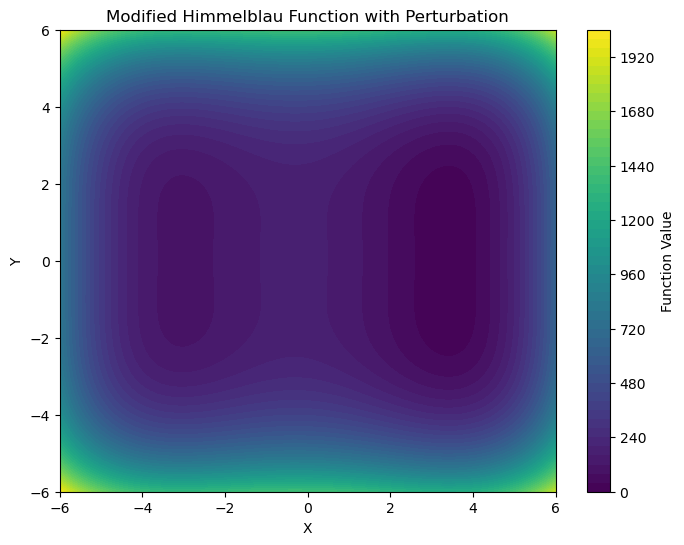

In [5]:
import numpy as np
import matplotlib.pyplot as plt


# Generate grid data
x = np.linspace(-6, 6, 100)
y = np.linspace(-6, 6, 100)
X, Y = np.meshgrid(x, y)
z = 0
F = modified_himmelblau((X, z, Y))

# Create contour plot
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, F, levels=50, cmap='viridis')
plt.colorbar(contour, label="Function Value")

# Labels and title
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Modified Himmelblau Function with Perturbation")

plt.show()

In [6]:
#find true min
init = [3, 2, 1]

# Initial guess (x0, y0, z0)
x0 = np.array([init[0], init[1], init[2]])

# Perform minimization using Nelder-Mead method
result = optimize.minimize(modified_himmelblau, x0, method='Nelder-Mead')

In [7]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.10660237449815824
             x: [ 2.992e+00  2.009e+00  9.859e-01]
           nit: 37
          nfev: 72
 final_simplex: (array([[ 2.992e+00,  2.009e+00,  9.859e-01],
                       [ 2.992e+00,  2.009e+00,  9.860e-01],
                       [ 2.992e+00,  2.009e+00,  9.859e-01],
                       [ 2.992e+00,  2.009e+00,  9.858e-01]]), array([ 1.066e-01,  1.066e-01,  1.066e-01,  1.066e-01]))

In [8]:
#find true min
init = [-2.8, 3.13, 1]

# Initial guess (x0, y0, z0)
x0 = np.array([init[0], init[1], init[2]])

# Perform minimization using Nelder-Mead method
result = optimize.minimize(modified_himmelblau, x0, method='Nelder-Mead')

In [9]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.490822111166734
             x: [-2.820e+00  3.132e+00  9.859e-01]
           nit: 44
          nfev: 86
 final_simplex: (array([[-2.820e+00,  3.132e+00,  9.859e-01],
                       [-2.820e+00,  3.131e+00,  9.859e-01],
                       [-2.820e+00,  3.131e+00,  9.859e-01],
                       [-2.820e+00,  3.131e+00,  9.860e-01]]), array([ 4.908e-01,  4.908e-01,  4.908e-01,  4.908e-01]))

In [10]:
#find true min
init = [-3.7, -3.2, 1]

# Initial guess (x0, y0, z0)
x0 = np.array([init[0], init[1], init[2]])

# Perform minimization using Nelder-Mead method
result = optimize.minimize(modified_himmelblau, x0, method='Nelder-Mead')

In [11]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -0.4246392934251789
             x: [-3.786e+00 -3.284e+00  9.859e-01]
           nit: 46
          nfev: 86
 final_simplex: (array([[-3.786e+00, -3.284e+00,  9.859e-01],
                       [-3.786e+00, -3.284e+00,  9.859e-01],
                       [-3.786e+00, -3.284e+00,  9.858e-01],
                       [-3.786e+00, -3.285e+00,  9.859e-01]]), array([-4.246e-01, -4.246e-01, -4.246e-01, -4.246e-01]))

In [12]:
#find true min
init = [3.5, -1.8, 1]

# Initial guess (x0, y0, z0)
x0 = np.array([init[0], init[1], init[2]])

# Perform minimization using Nelder-Mead method
result = optimize.minimize(modified_himmelblau, x0, method='Nelder-Mead')

In [13]:
result

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.2813876562479515
             x: [ 3.581e+00 -1.833e+00  9.859e-01]
           nit: 38
          nfev: 72
 final_simplex: (array([[ 3.581e+00, -1.833e+00,  9.859e-01],
                       [ 3.581e+00, -1.833e+00,  9.859e-01],
                       [ 3.581e+00, -1.833e+00,  9.860e-01],
                       [ 3.581e+00, -1.833e+00,  9.859e-01]]), array([ 2.814e-01,  2.814e-01,  2.814e-01,  2.814e-01]))

In [14]:
true_min = [-3.786e+00, -3.284e+00,  9.859e-01]

In [15]:
def scale_value(val, comp_lims, himmelblau_lims):
    scale = (val - comp_lims[0])/(comp_lims[1] - comp_lims[0])
    return scale*(himmelblau_lims[1] - himmelblau_lims[0]) + himmelblau_lims[0]


def scale_composition(composition, lower_bounds, upper_bounds, himmelblau_lims):
    scaled_comp = []
    for i, val in enumerate(composition):
        comp_lims = [lower_bounds[i], upper_bounds[i]]
        him_lims = [himmelblau_lims[i][0], himmelblau_lims[i][1]]
        scaled_comp.append(scale_value(val, comp_lims, him_lims))
    return scaled_comp

In [16]:
def unscale_value(val, comp_lims, himmelblau_lims):
    scale = (val - himmelblau_lims[0])/(himmelblau_lims[1] - himmelblau_lims[0])
    return scale*(comp_lims[1] - comp_lims[0]) + comp_lims[0]


def unscale_composition(composition, lower_bounds, upper_bounds, himmelblau_lims):
    scaled_comp = []
    for i, val in enumerate(composition):
        comp_lims = [lower_bounds[i], upper_bounds[i]]
        him_lims = [himmelblau_lims[i][0], himmelblau_lims[i][1]]
        scaled_comp.append(unscale_value(val, comp_lims, him_lims))
    return scaled_comp
    

In [17]:
def himmelblau_experiment(composition, lower_bounds, upper_bounds, himmelblau_lims, noise_val):

    noisy_point = [experiment.noisy_dispense(composition[0], noise_val), experiment.noisy_dispense(composition[1], noise_val), experiment.noisy_dispense(composition[2], noise_val)]
    him_comp = scale_composition(noisy_point, lower_bounds, upper_bounds, himmelblau_lims)
    him_val = modified_himmelblau(him_comp)
    return noisy_point, him_val

In [18]:
def himmelblau_for_contour(teos, ammonia, water):
    him_comp = scale_composition((teos, ammonia, water), lower_bounds, upper_bounds, himmelblau_lims)
    him_val = modified_himmelblau(him_comp)
    return him_val

In [19]:
def manage_experiment(batch, lower_bounds, upper_bounds, himmelblau_lims, noise_val):

    for uuid_val, sample in batch.items():
        point = [sample['teos_vol_frac'], sample['ammonia_vol_frac'], sample['ammonia_vol_frac'], sample['water_vol_frac']]
        real_point, func_val = himmelblau_experiment(point, lower_bounds, upper_bounds, himmelblau_lims, noise_val)
        batch[uuid_val]['real_sampled_point'] = real_point
        batch[uuid_val]['distance'] = func_val
    

## Parameters 

### SAXS Data processing parameters

### Experiment 'execution' parameters

In [20]:
# physical experiment bounds

teos_min_vf = 0.005
ammonia_min_vf = 0.005
water_min_vf = 0.005

teos_max_vf = 0.1
ammonia_max_vf = 0.1
water_max_vf = 0.15

lower_bounds = [teos_min_vf, ammonia_min_vf, water_min_vf]
upper_bounds = [teos_max_vf, ammonia_max_vf, water_max_vf]

noise_frac = 0.0 # what fraction of experimental noise to use

In [57]:
noise_frac

0.0

In [58]:
himmelblau_lims = [[-6,6], [-6,6], [-6,6]]

### Campaign structure 

In [59]:
m_samples = 6
batch_size = 1
budget = 50
sobol_seed = 42

trial_name = 'multi_obj_0'

NUM_RESTARTS = 50
RAW_SAMPLES = 512
nu = 5/2
ard_num_dims = 3

bounds_torch_norm = torch.tensor([(lower_bounds[0], upper_bounds[0]), (lower_bounds[1], upper_bounds[1]), (lower_bounds[2], upper_bounds[2])]).transpose(-1, -2)
bounds_torch_opt = torch.tensor([[0, 0, 0], [1.0, 1.0, 1.0]], dtype = torch.float32)

In [60]:

if batch_size == 0:
    n_batches = 0
else:
    n_batches = int(np.ceil(budget/batch_size))



print(f'Running optimization for trial {trial_name}')

print('starting initial samples')
initial_samples = init_sampling.sobol_sample(m_samples, sobol_seed, lower_bounds, upper_bounds)

# 2. 'measure' sobol samples

manage_experiment(initial_samples, lower_bounds, upper_bounds, himmelblau_lims, noise_frac)

# 3. start experiment loop:
data = initial_samples
for i in range(n_batches):
    print(f'starting batch {i+1}')
    # 3a. Prepare and run BO
    x_train, y_train = bo.bo_preprocess(data, bounds_torch_norm)
    candidates = bo.bayesian_optimize(x_train, y_train, batch_size, NUM_RESTARTS, RAW_SAMPLES, nu, ard_num_dims, bounds_torch_opt, bounds_torch_norm)
    candidates = bo.bo_postprocess(candidates)

    # run experiment
    manage_experiment(candidates, lower_bounds, upper_bounds, himmelblau_lims, noise_frac)

    # update running data tally
    for uuid_val, sample in candidates.items():
        data[uuid_val] = sample

    
   # with open(f'{trial_name}_replicate_{rep_num}.pkl', 'wb') as f:
   #     pickle.dump(data, f)

Running optimization for trial multi_obj_0
starting initial samples
starting batch 1
Optimized acqf in 2.378979206085205 s
starting batch 2
Optimized acqf in 1.9312820434570312 s
starting batch 3
Optimized acqf in 1.1769702434539795 s
starting batch 4
Optimized acqf in 1.5490460395812988 s
starting batch 5
Optimized acqf in 3.8028886318206787 s
starting batch 6
Optimized acqf in 5.73596978187561 s
starting batch 7
Optimized acqf in 4.990221261978149 s
starting batch 8
Optimized acqf in 5.669041156768799 s
starting batch 9
Optimized acqf in 5.560510873794556 s
starting batch 10
Optimized acqf in 6.247542381286621 s
starting batch 11
Optimized acqf in 4.5447728633880615 s
starting batch 12
Optimized acqf in 2.405749797821045 s
starting batch 13
Optimized acqf in 3.3152480125427246 s
starting batch 14
Optimized acqf in 8.082736015319824 s
starting batch 15
Optimized acqf in 7.06834077835083 s
starting batch 16
Optimized acqf in 8.72857403755188 s
starting batch 17
Optimized acqf in 18.736

In [61]:
with open('multiobj_noisefree_batch1_64sobol_50samples.pkl', 'wb') as f:
    pickle.dump(data, f)

## 8. Analyze 

#### 1. Convergence plot + metrics

In [62]:
n_replicates = 1
convergence_threshold = 0.05

In [63]:
data_complete = {}
data_campaigns = []
best_distances_list = []
best_uuids_list = []
converge_iterations = []
best_composition_dist = []
converge_uuid = []
for i in range(n_replicates):
    #with open(f'{fp}{trial_name}_replicate_{i}.pkl', 'rb') as f:
    #    data = pickle.load(f)
    
    name_bounds = {}
    name_bounds['random'] = (0, 2**m_samples)
    for i in range(n_batches):
        name_bounds[f'Batch {i+1}'] = ((i)*batch_size + 2**m_samples, (i+1)*batch_size + 2**m_samples)

    best_distances_ap = []
    best_uuid = []
    converge_its = None
    
    for i, (uuid_val, sample) in enumerate(data.items()):
        data_complete[uuid_val] = sample
        dist = sample['distance']
        if len(best_distances_ap) == 0:
            best_distances_ap.append(dist)
            best_distances_ap.append(dist)
            best_uuid.append(uuid_val)
        else:
            best_distances_ap.append(min(best_distances_ap[-1], dist))
    
        
        if dist < best_distances_ap[-2]:
            #print('new min found')
            best_uuid.append(uuid_val)

        if dist < convergence_threshold and converge_its is None:
            converge_its = i
            converge_iterations.append(i)
            converge_uuid.append(uuid_val)
    if converge_its is None:
        converge_iterations.append('Not converged')
        
    best_distances_list.append(best_distances_ap)
    best_uuids_list.append(best_uuid)
    data_campaigns.append(data)

    # get best composition distance
    best_sample = data[best_uuid[-1]]
    best_sample_comp = [best_sample['teos_vol_frac'], best_sample['ammonia_vol_frac'], best_sample['water_vol_frac']]
    comp_dist = post_process.composition_distance(best_sample_comp, true_min)
    best_composition_dist.append(comp_dist)

In [64]:
best_composition_dist

[5.181982]

In [65]:
best_distances_list

[[85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  85.1849728979389,
  44.894856048518804,
  44.894856048518804,
  44.894856048518804,
  44.894856048518804,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,
  6.679738554135987,

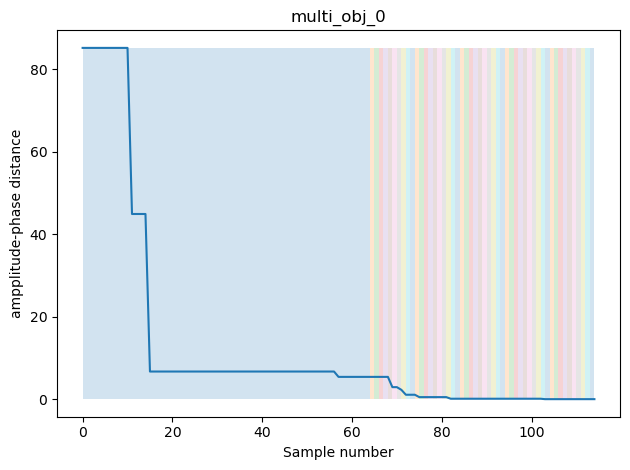

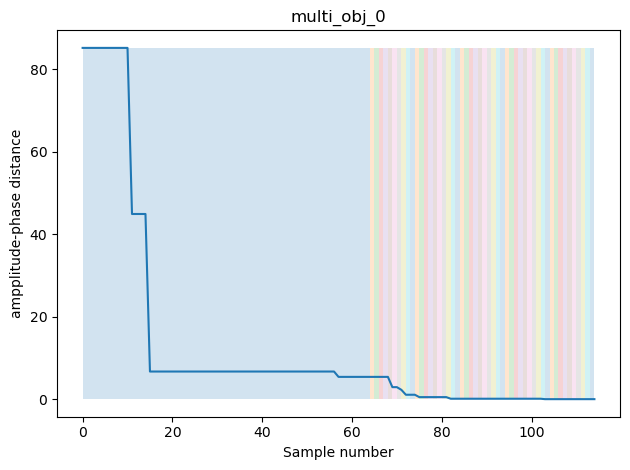

In [66]:
post_process.convergence_plot(data, best_distances_list, best_uuids_list, name_bounds, trial_name)

## Contour trajectory plot

In [67]:
n_grid = 100
import time
true_min_unscaled = unscale_composition(true_min, lower_bounds, upper_bounds, himmelblau_lims)

In [68]:
## Build contour plot
# Define grid
teos = np.linspace(teos_min_vf, teos_max_vf, n_grid)
ammonia = np.linspace(ammonia_min_vf, ammonia_max_vf, n_grid)

water = true_min_unscaled[2] # set 3rd fixed value to optima
Teos, Ammonia = np.meshgrid(teos, ammonia)
t1 = time.time()
# Compute contour values
Z = np.vectorize(himmelblau_for_contour)(Teos, Ammonia, water)


with open('TEOS_ammonia_waterOptima_gridvals_MultiObj_50.npy', 'wb') as f:
    np.save(f, Z)
print(f'finished grid in {time.time() - t1} s')

finished grid in 0.07577252388000488 s


In [69]:
## Build contour plot

# Define grid
teos = np.linspace(teos_min_vf, teos_max_vf, n_grid)
water = np.linspace(water_min_vf, water_max_vf, n_grid)

ammonia = true_min_unscaled[1]
Teos, Water = np.meshgrid(teos, water)

# Compute contour values
Z = np.vectorize(himmelblau_for_contour)(Teos, ammonia, Water)


with open('TEOS_water_ammoniaOptima_gridvals_MultiObj_50.npy', 'wb') as f:
    np.save(f, Z)

In [72]:
with open('TEOS_water_ammoniaOptima_gridvals_MultiObj_50.npy', 'rb') as f:
    Z_ammonia = np.load(f)

with open('TEOS_ammonia_waterOptima_gridvals_MultiObj_50.npy', 'rb') as f:
    Z_water = np.load(f)

In [73]:
ammonia = np.linspace(ammonia_min_vf, ammonia_max_vf, n_grid)
water = np.linspace(water_min_vf, water_max_vf, n_grid)
teos = np.linspace(teos_min_vf, teos_max_vf, n_grid)

In [74]:
len(data_campaigns)

1

In [77]:
n_batches = 50

Animation saved as multiobj_50.html


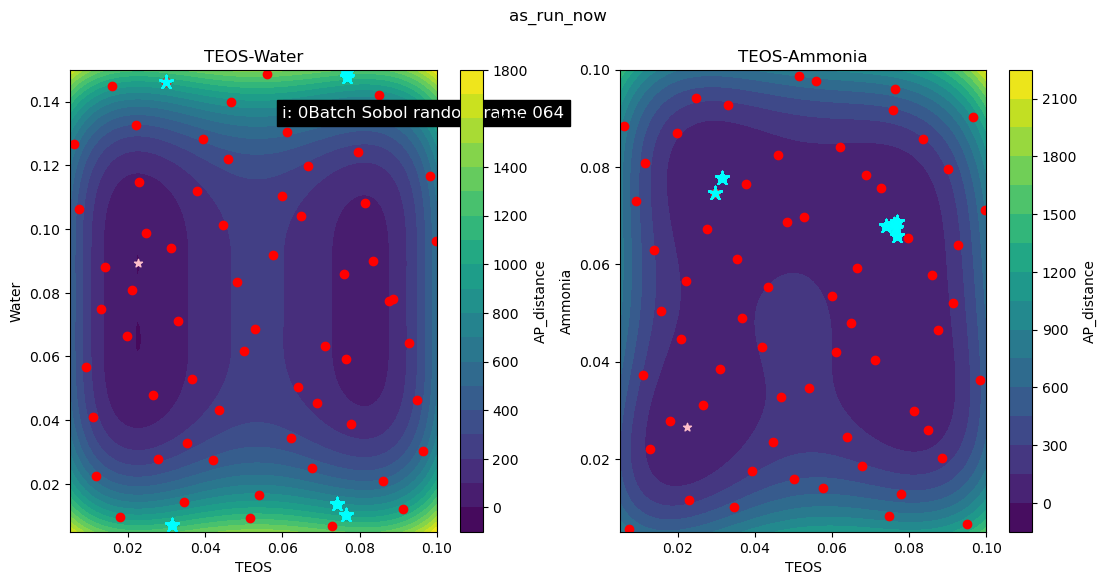

In [78]:
anim = contour_animated.ContourAnimation(ammonia, water, teos, Z_ammonia, Z_water, 
                        data_campaigns[0], best_uuids_list[0], n_batches, true_min_unscaled, 'as_run_now', n_grid, m_samples, batch_size)

anim.save("multiobj_50.html", format="html")  # Saves as an HTML file

In [134]:
unscale_composition(true_min, lower_bounds, upper_bounds, himmelblau_lims)

[0.022527500000000002, 0.02650166666666667, 0.08941295833333333]

In [86]:
true_min

[-3.786, -3.284, 0.9859]

In [80]:
true_min

[-3.786, -3.284, 0.9859]

In [81]:
modified_himmelblau(true_min)

-0.4246243458168172

In [83]:
distances = []
for uuid_val, sample in data.items():
    distances.append(sample['distance'])

In [85]:
min(distances)

-0.022524694261265493